# Финальный проект по треку ML
### Автор: Анна Мороз, 3 курс




#### Введение
Для выполнения этого проекта я выбрала KMAtest Kaggle Competition, основной задачей которого является сделать наиболее точной предсказание общей оценки пива (переменная review_overall) по шкале от 1 до 5, основываясь на таких зависимых переменных как название пивоварни и самого пива, время оценки, оценка запаха пива, его внешнего вида, вкуса, ощущений на вкусовых рецепторах (review_palate), имя оценивающего и процентное содержание алкоголя.
Данные для этого соревнования доступны по ссылке: <https://www.kaggle.com/c/kmatest1/data> 

Итак, let's get started.
Для начала загрузим все библиотеки, которые могут понадобиться в процессе.

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.gridspec as gridspec
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 16, 10 

ModuleNotFoundError: No module named 'mlxtend'

Теперь загрузим данные, с которыми будем работать. Так как у меня были некоторые проблемы с Kaggle API, я для своего удобства и сохранения времени загрузила оба доступных датасета (train.csv и test.csv) в репозиторий Google Colaboratory и уже оттуда подгружаю их в рабочий notebook. 
Датасет test.csv понадобится только ближе к концу для создания файла с предсказаниями для отправки на Kaggle, поэтому сейчас давайте загрузим и посмотрем на датасет train.csv, по которому будут обучаться модели и будет оцениваться их точность.

In [4]:
beer_train = pd.read_csv("train.csv")
beer_train.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,id
0,184,Bierbrouwerij De Koningshoeven B.V.,1245476843,4.0,4.0,3.5,ChainGangGuy,Quadrupel (Quad),4.0,4.0,La Trappe Quadrupel (Koningshoeven / Dominus),10.0,1402,1
1,192,New Belgium Brewing,1232935341,4.0,3.0,4.0,ChainGangGuy,American Amber / Red Ale,3.0,3.5,Fat Tire Amber Ale,5.2,607,2
2,2210,Firestone Walker Brewing Co.,1273891780,3.0,3.0,3.5,womencantsail,American Pale Wheat Ale,3.5,3.0,Solace,6.0,57242,3
3,1114,Bullfrog Brewery,1276460993,4.0,4.5,4.0,womencantsail,American Wild Ale,5.0,4.5,Black Cherry Bomb,NaN,44934,4
4,6045,Iron Hill Brewery & Restaurant,1304735131,4.0,4.5,4.0,akorsak,Saison / Farmhouse Ale,4.0,4.5,Samurai Saison,6.8,68766,5


In [6]:
beer_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7859 entries, 0 to 7858
Data columns (total 14 columns):
brewery_id            7859 non-null int64
brewery_name          7859 non-null object
review_time           7859 non-null int64
review_overall        7859 non-null float64
review_aroma          7859 non-null float64
review_appearance     7859 non-null float64
review_profilename    7859 non-null object
beer_style            7859 non-null object
review_palate         7859 non-null float64
review_taste          7859 non-null float64
beer_name             7859 non-null object
beer_abv              7180 non-null float64
beer_beerid           7859 non-null int64
id                    7859 non-null int64
dtypes: float64(6), int64(4), object(4)
memory usage: 859.7+ KB


#### Эксплораторный анализ
Датасет содержит в себе 7 589 наблюдений и 14 переменных, вместе с предсказываемой переменной. 10 переменных являются числовыми, а оставшиеся 4 - категориальными. 
Давайте проведем небольшую разведку данных и выясним, действительно ли все переменные так уж необходимы для построения хорошего предсказания. 
Во-первых, посмотрим, сколько и в каких колонках содержатся пропущенные значения.

In [7]:
beer_train.isna().sum()[beer_train.isna().sum()>0] 

beer_abv    679
dtype: int64

Судя по всему, отсутствуют значения только в одной переменной, beer_abv, состаляя около 8%. Что не так уж много.
Далее я бы хотела в визуализировать числовые переменные-предикторы и посмотреть на их корреляцию с предсказываемой  переменной. Однако, чтобы это сделать, мне нужно предварительно избавиться от переменных, содержащих в себе id. Так как смысла для модели они в себе не несут, а тип у них числовой.

In [8]:
train = beer_train.drop(['brewery_id', 'id', 'beer_beerid'], axis=1) 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7859 entries, 0 to 7858
Data columns (total 11 columns):
brewery_name          7859 non-null object
review_time           7859 non-null int64
review_overall        7859 non-null float64
review_aroma          7859 non-null float64
review_appearance     7859 non-null float64
review_profilename    7859 non-null object
beer_style            7859 non-null object
review_palate         7859 non-null float64
review_taste          7859 non-null float64
beer_name             7859 non-null object
beer_abv              7180 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 675.5+ KB


От ненужного избавились, можно строить гистограммы по числовым переменным.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee7a986518>,
      dtype=object)

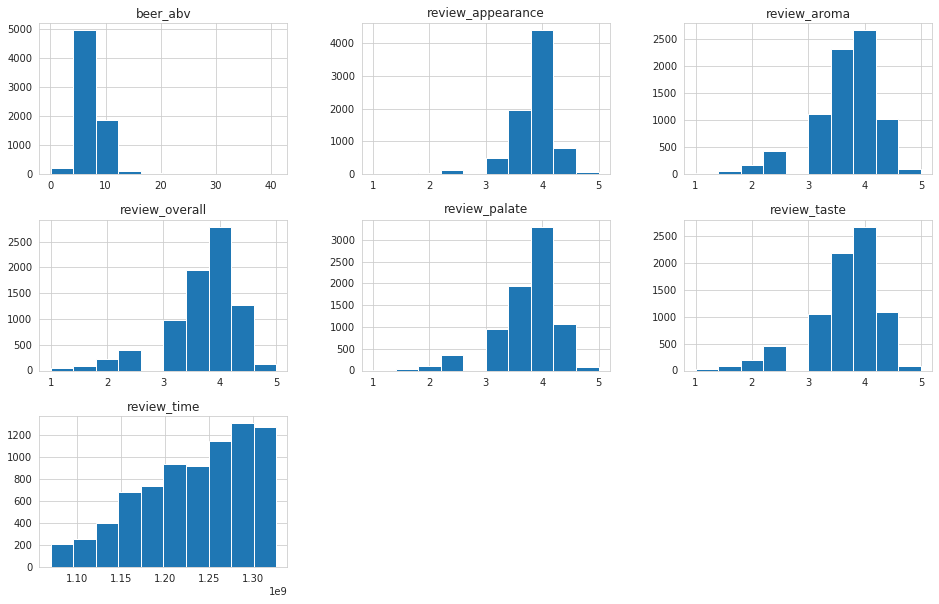

In [9]:
sns.set_style("whitegrid")
train.select_dtypes(include=np.number).hist()

Судя по визуализации, предсказываемая переменная распределенна почти нормально, но ее распределение немного скошено вправо.
Теперь давайте глянем на корреляции.

In [10]:
(train.corr()**2)["review_overall"].sort_values(ascending = False)[1:]

review_taste         0.733620
review_aroma         0.548199
review_palate        0.490436
review_appearance    0.251971
beer_abv             0.008394
review_time          0.004874
Name: review_overall, dtype: float64

Переменные review_time и beer_abv коррелируют с предсказываемой переменной очень слабо. Скорее всего их эффект в предсказании будет незначительным, а значит их можно убрать.
Ради интереса визуализируем отношения каждой из оставшихся числовых переменных-предикторов и предсказываемой переменной.

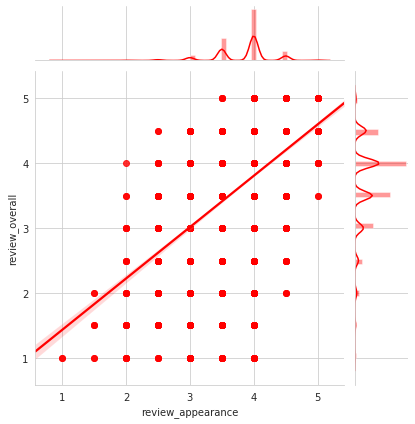

In [11]:
# переменная 'review_appearance'
sns.jointplot(x = "review_appearance", y = "review_overall", data = train, kind = "reg", color = 'red')

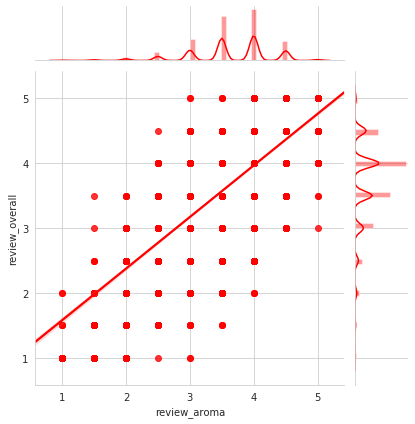

In [12]:
# переменная 'review_aroma'
sns.jointplot(x = "review_aroma", y = "review_overall", data = train, kind = "reg", color = 'red')

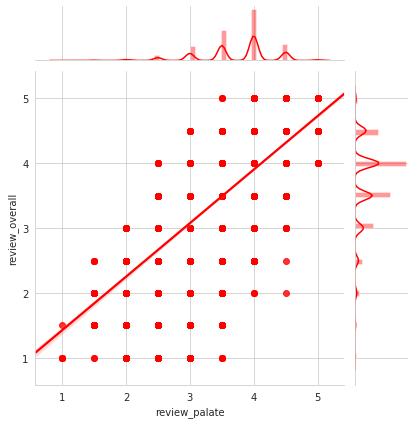

In [13]:
# переменная 'review_palate'
sns.jointplot(x = "review_palate", y = "review_overall", data = train, kind = "reg", color = 'red')

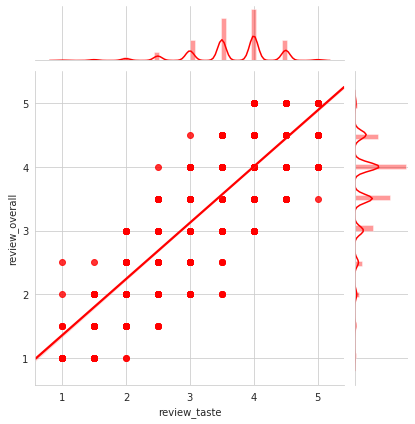

In [14]:
# переменная 'review_taste'
sns.jointplot(x = "review_taste", y = "review_overall", data = train, kind = "reg", color = 'red')

И хотя скаттерплоты выглядят немного необычно из-за того, что все переменные, используемые в них, являются дискретными, тренд зависимости четко прослеживается.
Окей, с числовыми закончили, переходим к категориальным. Давайте посмотрем на статистику по данным в них.

In [15]:
train.describe(include=['object'])

,brewery_name,review_profilename,beer_style,beer_name
count,7859,7859,7859,7859
unique,862,4,103,5189
top,Tröegs Brewing Company,BuckeyeNation,American IPA,Pale Ale
freq,155,2347,523,16


Впечатляюще, в некоторых пременных чересчур много уникальных значений. А так как для построения моделей мне придется перекодировать все категориальные переменные в dummy-переменные, это все может вылится в непомерное количество предикторов. Что приведет к ненужному переобучению. Чтобы этого избежать, я избавлюсь от переменных 'brewery_name' и 'beer_name'. 
Давайте визуализируем оставшиеся переменные, чтобы понять есть ли у каждой зависимость с пресказываемой переменной.

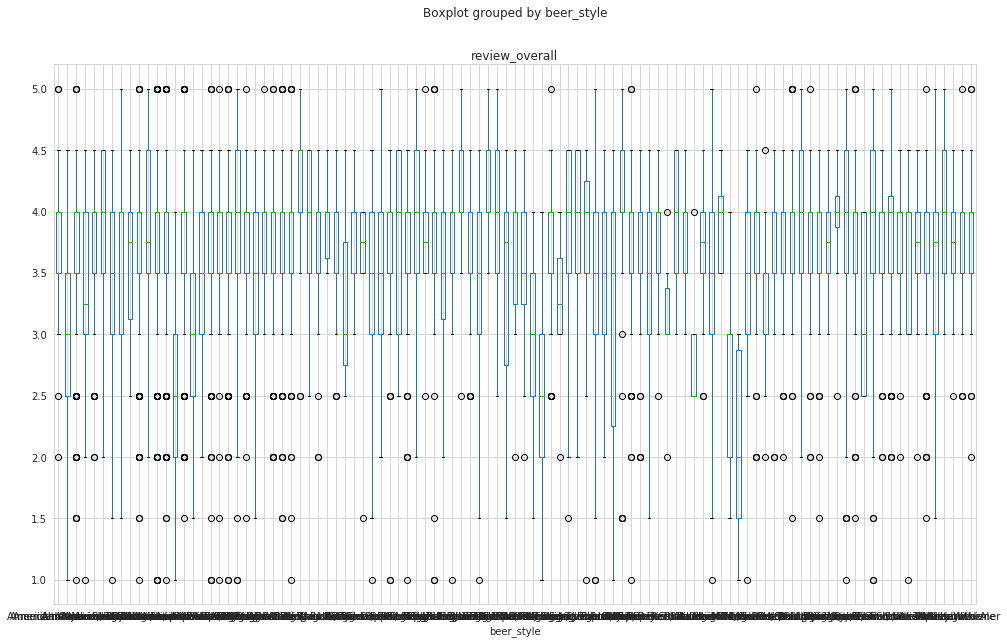

In [0]:
# переменная 'beer_style'
train.boxplot('review_overall','beer_style')

И хотя данный график весьма тяжело воспринимается (а визуализация 103 категорий по другому и не получится), приглядевшись, можно понять, что медианы и inter-quartile range некоторых категорий все же различаются. А значит зависимость между предиктором и зависимой переменной есть.
Идем дальше.

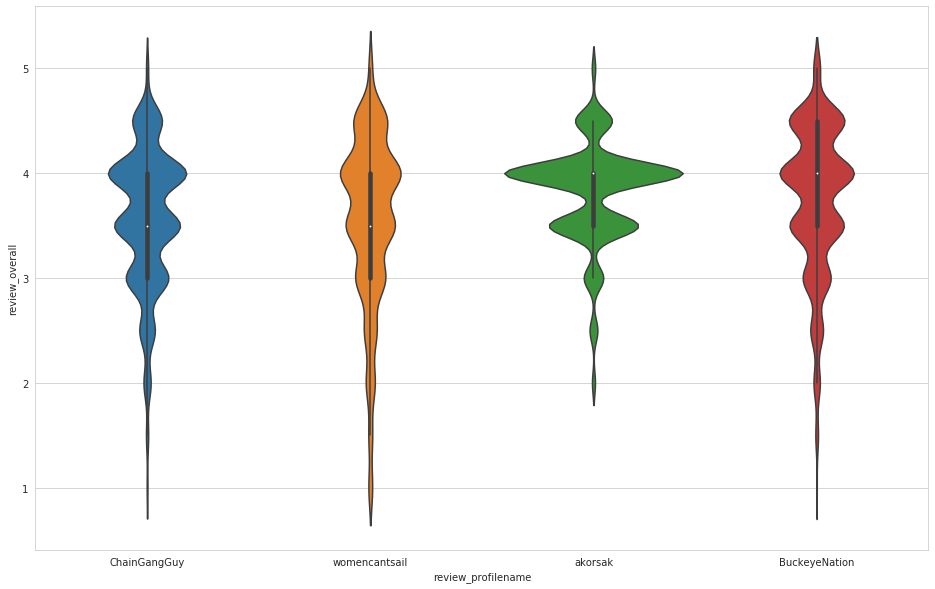

In [16]:
# переменная 'review_profilename'
sns.violinplot(x="review_profilename", y="review_overall", data=train) 

То же самое для этой переменной, но уже гораздо лучше считываемое - медианы и inter-quartile range некоторых категорий различаются, а значит зависимость между предиктором и зависимой переменной есть.
На этом, я считаю, разведывательный анализ можно закончить и, удалив из датасета все переменные, которые мы посчитали ненужными, продолжить с построением модели.

#### Манипуляции с данными

In [17]:
train_drop = train.drop(['beer_abv', 'review_time', 'brewery_name', 'beer_name'], axis=1)
train_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7859 entries, 0 to 7858
Data columns (total 7 columns):
review_overall        7859 non-null float64
review_aroma          7859 non-null float64
review_appearance     7859 non-null float64
review_profilename    7859 non-null object
beer_style            7859 non-null object
review_palate         7859 non-null float64
review_taste          7859 non-null float64
dtypes: float64(5), object(2)
memory usage: 429.9+ KB


Еще одна маленькая деталь, оставшиеся категориальные переменные надо перекодировать в dummy-переменные.

In [18]:
data = pd.get_dummies(train_drop).reset_index(drop=True)
data.shape

(7859, 112)

Отлично, таким образом, у нас осталось 112 колонок, 111 из которых это предикторы для модели. Далее можно разделить датасет на тестовую и обучающуюся выборки: на одной модели будут строится, а на другой будет оцениваться их работа.

In [0]:
y = train['review_overall'].reset_index(drop=True)
X = data.iloc[:len(y), :]

X_sub = data.iloc[len(y):, :]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0)

Посмотрим на структуру получившихся выборок.

In [23]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6287, 112), (6287,), (1572, 112), (1572,))

#### Построение моделей
Теперь можно приступить к построению моделей. Итого я планирую сделать 7 моделей, подсчитывая среднюю кваратичную ошибку квадратного отклонения (RMSE metric) их предсказаний, и по итогу выбрать 2 наиболее точно предсказывающие модели. Модели будут включать в себя Ridge и Lasso регрессии, дерево решений, случайный лес, градиентный бустинг и 2 ансамбля из нескольких предыдущих моделей.
Чтобы избежать переобучения, я собираюсь использовать кросс-валидацию с 8 фолдами.

In [0]:
kfolds = KFold(n_splits=8, shuffle=True, random_state=8808)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

Следующий чанк с кодом сохраняет значения для параметра alpha, необходимого, чтобы указать **Ridge** и **Lasso** регрессиям, насколько сильной должна быть пенализация весов предикторов, в зависимости от их количества.
Оптимальный параметр alpha для модели подбирается вручную. Однако, чтобы не строить модели по несколько раз, я созранила все значения, которые собиралась попробовать заранее. Эти значения различаются в десятках, так как в пределах одной десятой числа alpha разницы между силой пенализации как таковой нет.

In [0]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]

Теперь можно посмтроить модели.

In [0]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas, cv=kfolds)) 

ridge_mod = ridge.fit(X_train, y_train)
y_predRidge = ridge_mod.predict(X_test)

rmseR = rmsle(y_test, y_predRidge)

In [27]:
 f'{rmseR:.20f}'

'0.00000000121882318573'

Хорошее начало. Средне-кваратичная ошибка квадратного отклонения довольно мала, учитывая, что шкала предсказывемой переменной берется от 1 до 5.

In [0]:
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=alphas, random_state=8808, cv=kfolds))

lasso_mod = lasso.fit(X_train, y_train)
y_predLasso = lasso_mod.predict(X_test)

rmseL = rmsle(y_test, y_predLasso)

In [29]:
 f'{rmseL:.20f}'

'0.00000693756723672936'

Здесь ошибка выходить чуть больше, но все еще довольно маленькая.

Следующая модель - **дерево решений**. Для нее я задаю несколько гипер-параметров. Один из них - max_depth, определяющий глубину дерева. Перепробовав значения 4,5,7, я остановилась на последнем. Второй гипер-параметр, min_samples_leaf, определяет минимальное количество наблюдений, которое должно оказаться в терминальном листе дерева. Тут я пробовала значения от 20 до 50, и оказалось, что со значения 34 и ниже дерево начинает предсказывать идеально, RMSE становится по нулям. Не знаю, насколько это возможно, но here it goes.

In [0]:
dtree20 = DecisionTreeRegressor(max_depth = 7, min_samples_leaf = 20, random_state = 8808)  
  
dtree20_mod = dtree20.fit(X_train, y_train)
y_predDtree20 = dtree20_mod.predict(X_test)

rmseD20 = rmsle(y_test, y_predDtree20)

In [33]:
f'{rmseD20:.20f}'

'0.00000000000000000000'

Далее модель **градиентного бустинга**. Тут гипер-параметров чуть больше, чем в дереве. 
> *n_estimators*: количество деревьев, на которых бустинг будет учится. Я пробовала значения 1000, 2000, 3000, 5000, второе оказалось самым действенным (в комбинации с остальными гипер-параметрами).

> *learning_rate*: параметр, определяющий, как быстро бустинг будут учится. Значение по дефолту у него 0.1, и, чем ближе к 1 это значение, тем быстрее модель обучается. В то время как 1 будет значить переобучение. Я начала с 0.01 и шла по возрастанию. Оказалось, что чем больше это значение, чем меньше ошибка в предсказании. Это наталкивает на мысль, что возможно для этих данных такая специфическая модель как бустинг не подходит, раз наименьшую ошибку оно выдает при состоянии переобучения, по сути.

> *max_depth*: определяет глубину каждого отдельного дерева, которое используется бустингом в процессе построения итоговой модели. Тут я просто оставила то же значение, что использовала в дереве решений.

> *max_features*: определяет количество предикторов, которые рассматривает модель при каждом сплите. Вариантов этого значения несколько, я остановилась на 'auto', что означает равное кол-ву предикторов в инпуте моделе, так как все остальные версии строго давали ошибку предсказания больше 0.1.

> *min_samples_leaf*: определяет минимальное количество наблюдений, которое остается в терминальном ноде. Перепробовав, значения от 10 до 120, я решила, что оптимальное, вместе с остальными гипер-параметрами, все-таки 10.

> *min_samples_split*: минимальное количество наблюдений, необходимое, чтобы сделать сплит в промежуточных нодах. Тут были варианты в интервале от 20 до 80, конечным стало именно значение 50.

> *loss*: определяет функцию потерь, которую нужно оптимизировать. Я выбрала 'ls', что означает метод регрессии с помощью наименьших квадратов, так как остальные варианты не делали предсказание бустинга лучше.

In [0]:
gbr = GradientBoostingRegressor(n_estimators=2000, 
                                learning_rate=0.8, 
                                max_depth=7, 
                                max_features='auto', 
                                min_samples_leaf=10, 
                                min_samples_split=50, 
                                loss='ls', 
                                random_state =8808) 
gbr_mod = gbr.fit(X_train, y_train)
y_predGBR = gbr_mod.predict(X_test)

rmse_gbr = rmsle(y_test, y_predGBR)

In [44]:
 f'{rmse_gbr:.20f}' 

'0.00022743127993164308'

Тут ошибка предсказание уже существенно больше, чем у предыдущих моделей.

Следующая модель - **случайный лес**. Гипер-параметры для нее следующие
> *n_estimators*: количество деревьев, которые лес построит. Перепробовав значения 500, 1000, 2000, самым действенным оказалось второе(в комбинации с остальными гипер-параметрами).

> *max_depth*: определяет глубину каждого отдельного дерева. Тут я пробовала значения 2,4,7, но в итоге оставила то же, что использовала в дереве решений и бустинге.

> *max_features*: определяет количество предикторов, которые рассматривает модель при каждом сплите. Поставлено 'auto', как и в бустинге, по аналогичным причинам.

> *min_samples_leaf*: определяет минимальное количество наблюдений, которое остается в терминальном ноде. Я просто оставила то же , что было в градиентном бустинге.

> *min_samples_split*: минимальное количество наблюдений, необходимое модели, чтобы сделать сплит в промежуточных нодах деревьев. Опять же, значение выбрано по аналогии с моделью бустинга.

In [0]:
rf = RandomForestRegressor(n_estimators = 1000, 
                           max_depth = 4, 
                           min_samples_split = 50, 
                           min_samples_leaf=10,
                           max_features = 'auto', 
                           random_state = 8808)

rf_mod = rf.fit(X_train, y_train)
y_predRF = rf_mod.predict(X_test)

rmseRF = rmsle(y_test, y_predRF)

In [48]:
f'{rmseRF:.20f}'

'0.00002584983876772358'

И хотя гипер-параметры были установлены почти такие же, как и в моделе бустинга, ошибка предсказания у случайного леса меньше. Тем не менее, она все еще больше, чем у моделей дерева решений и регрессий.

Таким образом, самой лучшей моделью себя на данный момент показывает дерево решений. Второе место почетно занимает Ridge-регрессия, а сразу за ней идет Lasso-регрессия.
Теперь же я хочу построить *ансамбль* из этих трех моделей, руководствуясь логикой, что их одиночные предсказания в совместном применении должны давать еще более точный результат.

Для начала я попробую самый простой ансамбль, сложив предсказания трех моделей и поделив это на количество моделей. 

In [0]:
average_pred=(y_predLasso+y_predRidge+y_predDtree20)/3
rmseAv = rmsle(y_test, average_pred)

In [50]:
f'{rmseAv:.20f}'

'0.00000231270176068768'

Да, ошибка действительно стала меньше, чем у обеих регрессий, но все еще не дотягивает до уровня совершенства дерева.

Попробуем более сложный ансамбль c помощью **StackingCVRegressor**. Это двухуровневый алгоритм, который на первом уровне берет несколько регрессионных моделей и строит по тренировочной выборке модель и предсказания по ней, который уже на втором уровне передаются в еще одну регрессионную модель, имеющую название мета-регрессора. Чтобы избежать переобучения таким путем, в ансамбль уже встроена кросс-валидация.
Схематичное изображение того, как это работает, можно посмотреть на картинке снизу.

![alt text](http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor_files/stacking_cv_regressor_overview.png)

В качестве регрессоров первого уровня я поставила Ridge и Lasso регрессии, а в качестве мета-регрессора - дерево решений, так как оно дает наименьшую ошибку предсказания по трем моделям.

In [0]:
stack = StackingCVRegressor(regressors=(lasso, ridge),
                            meta_regressor=dtree20, 
                            use_features_in_secondary=True)

stack_mod = stack.fit(np.array(X_train), np.array(y_train))
y_predStack = stack_mod.predict(np.array(X_test))

rmseSt = rmsle(y_test, y_predStack)

In [52]:
f'{rmseSt:.20f}'


'0.00000000000000000000'

И о, вау, получаю идеальное предсказание с ошибкой как у дерева решений.

На этом построение моделей я считаю правильным закончить, так как у меня очевидно появилось два несомненных лидера, которых я собираюсь использовать для сабмита на Kaggle Leaderboard.

На этом этапе мы наконец доходим до файла test.csv, который до этого лежал нетронутым, и делаем на нем предсказания по моделям дерева решений и StackingCVRegressor. Однако, чтобы сделать эти предсказания и собрать их в отдельный файл, нужно предварительно произвести те же манипуляции с предикторами, что и с файлом train.csv до этого.


#### Итог

In [53]:
beer_test = pd.read_csv("test.csv")
beer_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965 entries, 0 to 1964
Data columns (total 13 columns):
brewery_id            1965 non-null int64
brewery_name          1965 non-null object
review_time           1965 non-null int64
review_aroma          1965 non-null float64
review_appearance     1965 non-null float64
review_profilename    1965 non-null object
beer_style            1965 non-null object
review_palate         1965 non-null float64
review_taste          1965 non-null float64
beer_name             1965 non-null object
beer_abv              1782 non-null float64
beer_beerid           1965 non-null int64
id                    1965 non-null int64
dtypes: float64(5), int64(4), object(4)
memory usage: 199.7+ KB


In [54]:
beer_train = pd.read_csv("train.csv")
target_drop = beer_train.drop(['review_overall'], axis=1)

append = target_drop.append(beer_test)
append.shape

(9824, 13)

In [55]:
test_new = append.drop(['beer_abv', 'review_time', 'brewery_name', 'beer_name', 'brewery_id', 'id', 'beer_beerid'], axis=1)
test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9824 entries, 0 to 1964
Data columns (total 6 columns):
review_aroma          9824 non-null float64
review_appearance     9824 non-null float64
review_profilename    9824 non-null object
beer_style            9824 non-null object
review_palate         9824 non-null float64
review_taste          9824 non-null float64
dtypes: float64(4), object(2)
memory usage: 537.2+ KB


In [56]:
test_features = pd.get_dummies(test_new).reset_index(drop=True)
test_features.shape

(9824, 111)

In [57]:
test_features = data.iloc[:1965,]
test_features.shape

(1965, 112)

Окей, теперь все готово для построения двух итоговых предсказаний и сохранения их в отдельные файлы для сабмишена.

In [0]:
predictions1 = dtree20_mod.predict(test_features)

submission1 = pd.DataFrame({'Id': beer_test['id'], 'Predicted': predictions1})
submission1.to_csv('submission1.csv', index=False)

In [0]:
predictions2 = stack_mod.predict(test_features)

submission2 = pd.DataFrame({'Id': beer_test['id'], 'Predicted': predictions2})
submission2.to_csv('submission2.csv', index=False)

Ну что ж, на этом все. Спасибо за внимание, надеюсь, Вам понравилось :)

Два файла с предсказаниями я загрузила в выбранное соревнование на Kaggle. Однако почему-то на лидерборде мой профиль так и не отразился. Возможно это связано с тем, что соревнование уже завершилось (добавлено было около 2х недель назад). Прилагаю скрины двух моих сабмишенов:

![](https://sun9-63.userapi.com/c854128/v854128164/1ad3c4/oM6U6ZUdPeE.jpg)

![alt text](https://sun9-6.userapi.com/c854128/v854128164/1ad3ce/9UC-RibK9To.jpg)
К слову, если бы я и попала на лидерборд, то была бы последняя.

В любом случае мой профиль на Kaggle доступен по следующей ссылке:
<https://www.kaggle.com/ariarerra>